In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas import Series
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid
from datetime import datetime
from Data import Data

import itertools
from collections import Counter
import pickle

In [2]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
class_dic = load_obj("class_dic")

In [74]:
code = ['pt','es','it','gr','tr','cy','ir','tm','sy','iq','lb','jo','il','ps','sa','ye','om','qa','bh','kw','ae']

In [75]:
np.save("middle_east_cc.npy", code)

In [3]:
def deseasonalize_avg_std(data,freq=12):
    """
    The shape of data should be (time, index) 
    """
    n  = data.shape[1]
    N  = data.shape[0]
    data_deseasonal = np.zeros(data.shape)
    Avgs = np.zeros((n,freq))
    Stds = np.zeros((n,freq))
    for i in range(n):
        temp = np.copy(data[:,i])
        temp = np.ravel(temp)
        r = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            if temp[Idx].std() == 0:
                r[Idx] = 0
            else:
                r[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
            Avgs[i,j] = temp[Idx].mean()
            Stds[i,j] = temp[Idx].std()
        data_deseasonal[:,i] = np.copy(r)       
    return(data_deseasonal, Avgs, Stds)

In [4]:
def southern_season(data,s_index,n=6):
    data = pd.DataFrame(data)
    n_index = ~s_index
    data_south = pd.concat([data.iloc[s_index,n:].transpose(),data.iloc[s_index,:n].transpose()],ignore_index=True,sort=False, axis=0)
    data_north = data.iloc[n_index,:]
    data_south = data_south.transpose()
    d = pd.concat([data_north,data_south],ignore_index=False,sort=False, axis=1)
    d.iloc[s_index,:n*2] = d.iloc[s_index,n*2:]
    d.columns = list(np.arange(n*4))
    d = d.drop(d.columns[list(np.arange(n*2,n*4))], axis = 1)
    return(d)

In [5]:
def Ctype(Thot, Tmon10):
    if Thot >= 22:
        return('a')
    elif Tmon10 >= 4:
        return('b')
    elif (Tmon10 >= 1) and (Tmon10 < 4):
        return('c')

def Dtype(Thot, Tmon10, Tcold):
    if Thot >= 22:
        return('a')
    elif Tmon10 >= 4:
        return('b')
    elif (Tcold < -38):
        return('d')
    else:
        return('c')

In [6]:
def koppen_finder(data):

    pre = data[:12]
    air = data[12:]
    
    MAP = pre.sum()
    Pdry = pre.min()
    Pwinter = pre[:6].sum()
    Psummer = pre[6:].sum()
    Pwdry = Pwinter.min()
    Psdry = Psummer.min()
    Pwwet = Pwinter.max()
    Pswet = Psummer.max()


    MAT = air.mean()
    Tcold = air.min()
    Thot = air.max()
    Tmon10 = np.count_nonzero(air > 10)

    if Pwinter >= 0.7 * MAP:
        Pthresh = 2 * MAT
    elif Psummer >= 0.7 * MAP:
        Pthresh = 2 * MAT + 28 
    else:
        Pthresh = 2 * MAT + 14

    if MAP < 10 * Pthresh:
        if MAP < 5 * Pthresh:
            if MAT >= 18:
                return('BWh')
            else:
                return('BWk')
        else:
            if MAT >= 18:
                return('BSh')
            else:
                return('BSk')
        
    elif Tcold >= 18:
        if Pdry >= 60:
            return('Af')
        elif Pdry >= (100 - (MAP/25)):
            return('Am')
        else:
            return('Aw')
        
    elif Thot < 10:
        if Thot > 0:
            return('ET')
        else:
            return('EF')
      
    elif (Thot > 10) and (Tcold <18) and (Tcold > 0):
        if (Psdry < 40) and (Psdry < Pwwet/3):
            return('Cs{}'.format(Ctype(Thot, Tmon10)))          
        elif Pwdry < Pswet/10:
            return('Cw{}'.format(Ctype(Thot, Tmon10)))  
        else:
            return('Cf{}'.format(Ctype(Thot, Tmon10))) 
        
    elif (Thot > 10) and (Tcold <=0):
        if (Psdry < 40) and (Psdry < Pwwet/3):
            return('Ds{}'.format(Dtype(Thot, Tmon10, Tcold)))           
        elif Pwdry < Pswet/10:
            return('Dw{}'.format(Dtype(Thot, Tmon10, Tcold))) 
        else:
            return('Df{}'.format(Dtype(Thot, Tmon10, Tcold)))

    else:
        return('NAN')

In [7]:
start = 1901
end = 1930

In [8]:
spatial_limits={"lon_min":-23.75,"lon_max":58.75,"lat_min":-38.75,"lat_max":38.75}
temporal_limits = {"time_min":datetime(start, 1, 16, 0, 0),"time_max":datetime(end, 12, 16, 0, 0)}

In [9]:
d = Data('./nc/cru_ts4.05.1901.2020.pre.dat.nc','pre',temporal_limits=temporal_limits, spatial_limits=spatial_limits, missing_value=9.96921e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

index = np.where(result[0,:] != 9.96921e+36)[1]

result = result[:,index]
lon_list = np.array(lon_list)[index]
lat_list = np.array(lat_list)[index]

In [10]:
d = Data('./nc/cru_ts4.05.1901.2020.tmp.dat.nc','tmp',temporal_limits=temporal_limits,spatial_limits=spatial_limits, missing_value=9.96921e+36)

result_air = d.get_data()
lon_list_air = d.get_lon_list()
lat_list_air = d.get_lat_list()
lon_air = d.get_lon()
lat_air = d.get_lat()

index = np.where(result_air[0,:] != 9.96921e+36)[1]

result_air = result_air[:,index]
lon_list_air = np.array(lon_list_air)[index]
lat_list_air = np.array(lat_list_air)[index]

In [11]:
result.shape

(360, 12952)

In [12]:
result_air.shape

(360, 12952)

In [13]:
precipitation = result.copy()
temperature = result_air.copy()


precipitation, avgs_pre, stds_pre = deseasonalize_avg_std(precipitation)
temperature, avgs_temp, stds_temp = deseasonalize_avg_std(temperature)

In [14]:
avgs_pre = pd.DataFrame(avgs_pre)
avgs_air = pd.DataFrame(avgs_temp)

df = pd.DataFrame({"lons":lon_list,"lats":lat_list})

lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"] = lon_temp

s_index = (df["lats"] <= 0).values
n_index = (df["lats"] > 0).values

avgs_pre = southern_season(avgs_pre,s_index)
avgs_air = southern_season(avgs_temp,s_index)

#data = pd.concat([avgs_pre.transpose(),avgs_air.transpose()],ignore_index=True,sort=False, axis=0)

In [15]:
avgs_pre = pd.concat([avgs_pre.iloc[:,9:],avgs_pre.iloc[:,:9]],ignore_index=True,sort=False, axis=1)

In [16]:
avgs_air = pd.concat([avgs_air.iloc[:,9:],avgs_air.iloc[:,:9]],ignore_index=True,sort=False, axis=1)

In [17]:
data = pd.concat([avgs_pre.transpose(),avgs_air.transpose()],ignore_index=True,sort=False, axis=0)

In [18]:
data = data.transpose()

In [19]:
data

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,42.886669,6.086667,0.000000,0.000000,0.276667,0.786667,3.000000,0.000000,35.479996,27.173336,...,23.296665,22.053337,21.506666,21.519999,22.069998,22.526669,23.913334,24.956665,26.110004,26.720001
1,42.920002,12.230000,2.823333,3.573333,1.010000,1.500000,6.000000,0.000000,28.953333,23.180000,...,22.090002,20.859999,20.290001,20.316668,20.860003,21.423336,22.806667,23.956665,25.013334,25.613335
2,42.670002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.573330,29.916666,...,23.696665,22.456667,22.073336,22.030001,22.706665,23.043337,24.410000,25.476664,26.519999,27.126667
3,40.400002,4.143333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.033333,25.143335,...,22.806667,21.660000,21.173334,21.230001,21.796669,22.229998,23.709999,24.773336,25.826668,26.430000
4,37.186665,18.203337,10.496667,12.326667,2.663333,2.193333,5.000000,1.300000,17.206667,18.676666,...,22.900002,21.760002,21.453333,21.653334,22.106668,22.646666,24.076670,25.059999,26.043335,26.836666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12947,14.280001,15.789999,19.626669,29.730003,33.400002,56.156670,51.650005,36.536674,6.540001,0.000000,...,-0.450000,-2.566667,-0.736667,4.393333,10.310000,16.203333,20.976665,23.283333,21.690002,16.980001
12948,15.090000,15.806665,20.153334,30.053335,33.529999,58.720005,54.660000,39.500000,7.490001,0.000000,...,-1.270000,-3.293334,-1.533333,3.593333,9.726667,15.713334,20.590000,22.983335,21.296665,16.483335
12949,13.120000,13.443334,15.886667,23.080004,25.886667,46.546665,43.583336,30.516666,5.033333,2.133333,...,2.326667,0.310000,2.183333,7.300001,13.843334,20.123331,24.880003,27.273329,25.606665,20.373331
12950,8.276667,11.200000,12.466669,17.023333,20.119999,33.030003,31.723333,18.270000,3.473333,5.323333,...,4.603333,2.673334,4.593334,9.820001,16.773335,23.323334,27.986668,30.483332,28.700003,23.273336


In [20]:
climate = []
for i in range(data.shape[0]):
    climate.append(koppen_finder(data.iloc[i,:].values))

In [21]:
np.save("koppen_{}_{}.npy".format(start,end), climate)

In [254]:
df["clusters"] = climate

In [154]:
class_dic = load_obj("class_dic")

class_list = []
for i in range(len(lon_list)):
    lon, lat = lon_list[i], lat_list[i]
    if lon > 180: lon -= 360
    if (lat, lon) in class_dic.keys(): 
        class_list.append(class_dic[(lat, lon)])
    else:
        class_list.append(np.nan)
class_list = np.array(class_list)

In [255]:
col_index = np.array([False, False, True])
index = (df.lats > 36) & (df.lons < -0.4).values
df.loc[index, col_index] = np.nan

index = (df.lats > 12) & (df.lons > 44) &(df.lons < 49).values
df.loc[index, col_index] = np.nan

index = (df.lats > 34) & (df.lons > 11.55).values
df.loc[index, col_index] = np.nan

index = (df.lats > 18) & (df.lons > 40).values
df.loc[index, col_index] = np.nan

index = (df.lats > 19) & (df.lons > 38).values
df.loc[index, col_index] = np.nan

index = (df.lats > 24) & (df.lons > 35.5).values
df.loc[index, col_index] = np.nan

index = (df.lats > 15) & (df.lons > 41.5).values
df.loc[index, col_index] = np.nan

index = (df.lats > 13.5) & (df.lons > 43).values
df.loc[index, col_index] = np.nan

index = (df.lats > 27) & (df.lons > 34.97).values
df.loc[index, col_index] = np.nan

index = (df.lats > 27.7) & (df.lons > 33.68).values
df.loc[index, col_index] = np.nan

index = df.clusters == 'nan'
df.loc[index, col_index] = np.nan

In [256]:
df_list = []
for j in range(len(set(climate))):
    df_list.append(pd.DataFrame(columns=df.columns))

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


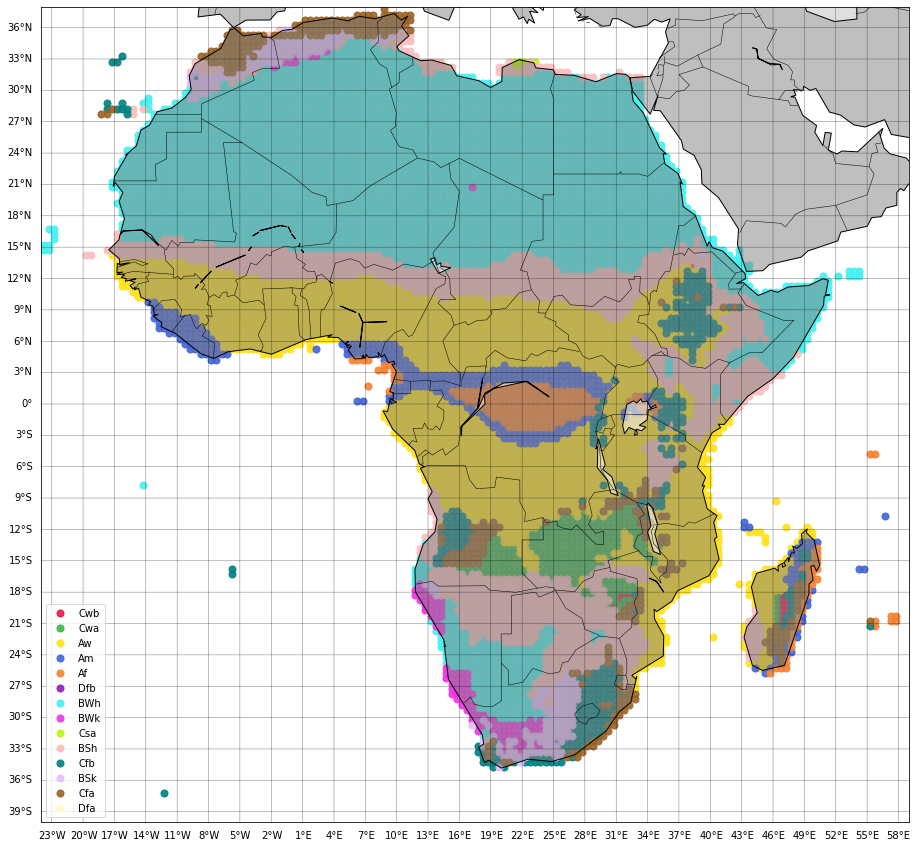

In [257]:
#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=59,urcrnrlat=38)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()
#colors = pf.random_color_1(n_components)
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
'#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

i = 0
for j in set(climate):
    values = df["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=50, label = j, c=colors[i])
    i+=1
    
    
plt.legend()
#plt.savefig("6_Clusters_non_standard.png")
plt.show()

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


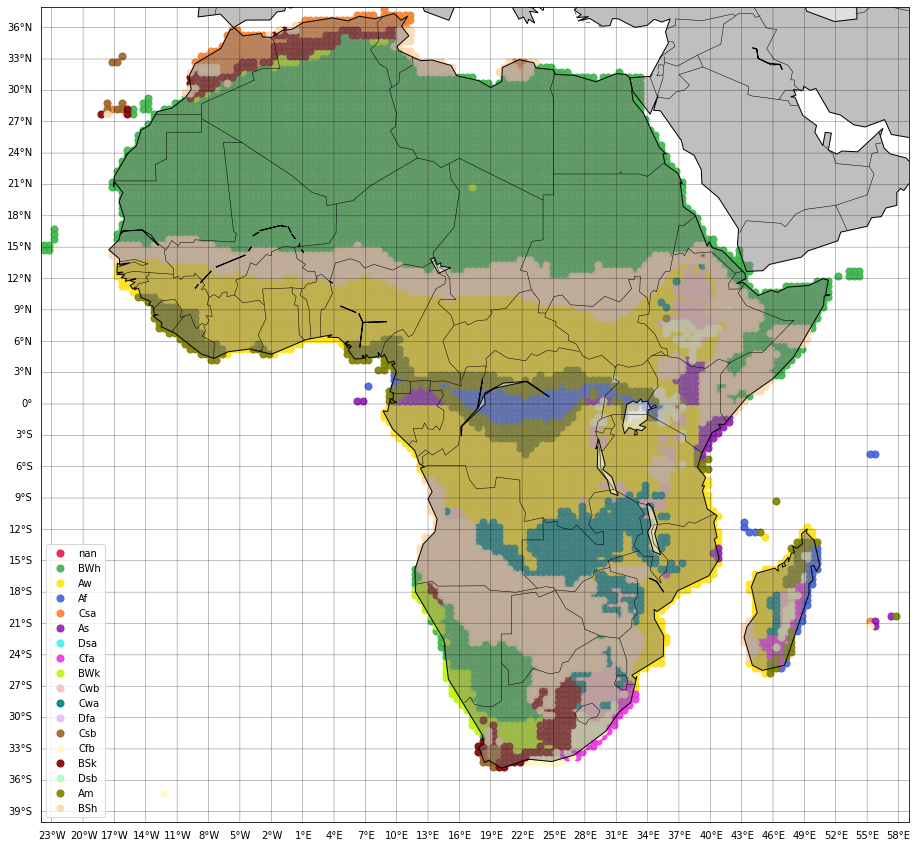

In [158]:
#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=59,urcrnrlat=38)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()
#colors = pf.random_color_1(n_components)
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
'#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

i = 0
for j in set(class_list):
    values = df["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=50, label = j, c=colors[i])
    i+=1
    
    
plt.legend()
#plt.savefig("6_Clusters_non_standard.png")
plt.show()

# Centrids from our Koppen Climate

In [204]:
np.save("af_index.npy", I)

In [237]:
len(I)

10662

In [ ]:
I = np.where(~pd.isna(df.clusters.values))[0]

In [22]:
I = np.load("af_index.npy")
#df_af = df.iloc[I,:]
data_af = data.loc[I,:]

In [23]:
climate = np.array(climate)
climate_af = climate[I]

In [24]:
data_af_norm = data_af/data_af.std()

 Major Classes

In [25]:
class_major = []
for i in range(len(climate_af)):
    class_major.append(climate_af[i][0])
class_major = np.array(class_major)

In [26]:
df_centroid = pd.DataFrame()
for c in list(set(class_major)):
    index = (class_major == c)
    df_centroid[c] = data_af_norm.iloc[index,:].mean(0).values

In [54]:
df_centroid = pd.DataFrame()
for c in list(set(class_major)):
    index = (class_major == c)
    df_centroid[c] = data_af.iloc[index,:].mean(0).values

In [27]:
df_centroid

,B,C,A
0,0.185117,0.855505,1.966151
1,0.172461,0.763660,1.497658
2,0.205028,0.904231,1.024632
3,0.207045,0.969552,0.906000
4,0.143399,0.910897,1.156980
5,0.140737,0.804020,1.505048
6,0.199042,0.931150,1.749183
7,0.244106,1.295603,2.037473
8,0.273962,1.590853,1.986966
9,0.435954,1.623246,1.920643


In [65]:
df_centroid = pd.concat([df_centroid,df_centroid_temp],ignore_index=True,sort=False, axis=0)

In [28]:
df_centroid.to_csv("centroids_majors_{}_{}_af_norm.csv".format(start,end))

In [26]:
pd.read_csv("centroids_majors_1901_2020_af.csv")

,A,B,C
0,156.751440,15.686442,68.353575
1,70.687678,7.997604,33.814361
2,26.872044,5.531979,23.611741
3,20.241521,4.564982,22.602539
4,30.614813,3.985217,24.728068
5,62.185448,5.802084,31.993382
6,102.859365,12.143198,57.064172
7,149.855690,18.622607,100.130729
8,172.941702,24.221014,144.377142
9,184.893552,41.817222,159.536099


In [80]:
df_centroid1 = pd.read_csv("centroids_majors_1901_2020_af_norm.csv")

In [85]:
df_centroid1["C"].values - df_centroid["C"].values

array([ 3.76243481e-12,  3.66083830e-11,  2.53592702e-11, -3.41926487e-11,
       -9.78117587e-12,  8.81406059e-12, -3.62065933e-11, -6.15529849e-12,
        9.37960820e-12, -2.01947348e-11, -2.18436380e-11, -9.51128065e-12,
        1.09805498e-11,  1.44857459e-11, -4.47011317e-11,  2.20086172e-11,
       -4.96522823e-11, -4.48010518e-11, -4.53876936e-11, -1.37925227e-11,
       -3.96775945e-11, -4.84687845e-11, -3.22959437e-11,  2.66950906e-11])

In [79]:
df_centroid

,B,A,C
0,0.198251,1.981085,0.863879
1,0.167507,1.480533,0.708232
2,0.212483,1.032153,0.906925
3,0.203433,0.902041,1.007257
4,0.149586,1.149135,0.928174
5,0.139947,1.499921,0.771684
6,0.204383,1.731237,0.960453
7,0.251771,2.025995,1.353732
8,0.279136,1.993076,1.663882
9,0.433188,1.915326,1.652646


In [260]:
df_centroid = pd.DataFrame()
for c in list(set(climate_af)):
    index = (climate_af == c)
    df_centroid[c] = data_af.iloc[index,:].mean(0).values

In [47]:
df_centroid = pd.DataFrame()
for c in list(set(climate_af)):
    index = (climate_af == c)
    df_centroid[c] = data_af_norm.iloc[index,:].mean(0).values

In [52]:
df_centroid

,BSh,Cfb,Csa,Cfa,Af,Cwa,Aw,BWh,Am,Cwb,BSk,BWk
0,0.489274,1.183502,0.520228,0.877300,2.523078,0.551394,1.808083,0.080564,2.954523,0.512262,0.420556,0.173999
1,0.319580,0.991782,1.033692,0.916263,3.275962,0.090572,1.138870,0.087383,2.777877,0.283731,0.564041,0.198298
2,0.303160,1.010927,3.435575,1.590965,4.060886,0.021269,0.585299,0.140355,2.391765,0.146412,0.984921,0.374100
3,0.249466,1.132627,3.806065,1.772478,4.114376,0.015665,0.453609,0.140578,2.117448,0.180990,1.073526,0.340192
4,0.192915,1.203325,2.406311,1.549393,4.238315,0.023249,0.670875,0.087064,2.661515,0.253099,1.023936,0.282705
5,0.244574,1.141586,1.107830,0.975971,3.464368,0.115321,1.149102,0.076528,2.907024,0.260789,0.683057,0.148545
6,0.492232,1.417558,0.266800,0.945446,2.805440,0.525617,1.521177,0.087783,2.626818,0.846841,0.604687,0.152434
7,0.682981,1.534450,0.047072,1.041272,2.334443,1.504549,1.914836,0.082132,2.634377,1.665261,0.493688,0.161170
8,0.827817,1.457744,0.001729,1.198785,1.868838,2.454588,1.942598,0.070252,2.423575,2.711268,0.357571,0.121525
9,1.115556,1.556188,0.000000,1.115112,1.608472,2.292262,1.895942,0.181266,2.195972,2.646953,0.333107,0.159189


In [49]:
df_centroid.to_csv("centroids_clustering_{}_{}_af_norm.csv".format(start, end))

In [51]:
start

1951

In [197]:
class_name = 'Cwb'

In [198]:
xyz = 0

In [199]:
class_data = df_centroid[class_name].values
dist= []

In [200]:
start_year = np.arange(1901,1996,5)
end_year = np.arange(1930,2025,5)
mid_year = np.arange(1915,2010,5)

In [201]:
temporal_limits = {"time_min":datetime(start_year[xyz], 1, 16, 0, 0),"time_max":datetime(end_year[xyz], 12, 16, 0, 0)}

d = Data('./nc/cru_ts4.05.1901.2020.pre.dat.nc','pre',temporal_limits,spatial_limits, missing_value=9.96921e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

index = np.where(result[0,:] != 9.96921e+36)[1]

result = result[:,index]
lon_list = np.array(lon_list)[index]
lat_list = np.array(lat_list)[index]

d = Data('./nc/cru_ts4.05.1901.2020.tmp.dat.nc','tmp',temporal_limits,spatial_limits, missing_value=9.96921e+36)

result_air = d.get_data()
lon_list_air = d.get_lon_list()
lat_list_air = d.get_lat_list()
lon_air = d.get_lon()
lat_air = d.get_lat()

index = np.where(result_air[0,:] != 9.96921e+36)[1]

result_air = result_air[:,index]
lon_list_air = np.array(lon_list_air)[index]
lat_list_air = np.array(lat_list_air)[index]

pre_list = list(zip(lon_list,lat_list))
air_list = list(zip(lon_list_air,lat_list_air))

precipitation = result.copy()
temperature = result_air.copy()

#precipitation = precipitation/precipitation.std()
#temperature = temperature/temperature.std()
#D = D/D.std()

precipitation, avgs_pre, stds_pre = deseasonalize_avg_std(precipitation)
temperature, avgs_air, stds_air = deseasonalize_avg_std(temperature)

avgs_pre = pd.DataFrame(avgs_pre)
avgs_air = pd.DataFrame(avgs_air)

df = pd.DataFrame({"lons":lon_list,"lats":lat_list})

lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"] = lon_temp

s_index = (df["lats"] <= 0).values
n_index = (df["lats"] > 0).values

avgs_pre = southern_season(avgs_pre,s_index)
avgs_air = southern_season(avgs_air,s_index)

avgs_pre = pd.concat([avgs_pre.iloc[:,9:],avgs_pre.iloc[:,:9]],ignore_index=True,sort=False, axis=1)
avgs_air = pd.concat([avgs_air.iloc[:,9:],avgs_air.iloc[:,:9]],ignore_index=True,sort=False, axis=1)

data = pd.concat([avgs_pre.transpose(),avgs_air.transpose()],ignore_index=True,sort=False, axis=0)
data = data.transpose()


In [205]:
data = data.loc[I,:]

In [206]:
data = data/data.std()

In [208]:
np.ones(data.T.shape).shape

(24, 10662)

In [209]:
class_data.reshape(-1,1).shape

(24, 1)

In [210]:
class_m = np.ones(data.T.shape)*class_data.reshape(-1,1)

In [211]:
class_data

array([0.49935051, 0.26301244, 0.14545108, 0.16383101, 0.22103654,
       0.23487383, 0.80565705, 1.63965681, 2.67966399, 2.51072341,
       2.08249352, 1.38352484, 5.19762581, 3.89924776, 2.84405374,
       2.60214757, 2.94051374, 3.66825508, 4.43440681, 4.8474222 ,
       4.7884568 , 5.00131073, 5.31232721, 5.72483045])

In [212]:
class_m.shape

(24, 10662)

In [213]:
dist.append(np.sqrt(((class_m-np.array(data).T) ** 2).sum(0)))

In [214]:
np.array(data).T.shape

(24, 10662)

In [215]:
data.loc[I,:].shape

(10662, 24)

In [217]:
dist

[array([ 5.83902914,  5.29216591,  6.10609317, ...,  8.36648656,
        11.30660565,  9.70921413])]

In [39]:
df_centroid

,Cwb,Cwa,Aw,Am,Af,BWh,BWk,Csa,BSh,Cfb,BSk,Cfa
0,39.843529,44.308313,145.165024,237.808069,197.681865,6.387595,13.625513,42.666002,39.331992,92.703706,33.366732,70.259535
1,12.653883,4.324260,55.144232,134.942847,157.005257,4.120728,9.540370,50.535501,15.530121,47.183674,27.384954,43.928338
2,3.764471,0.451097,15.130970,62.516565,105.461395,3.563934,9.936101,90.495001,7.956854,26.672115,25.917241,40.839349
3,3.729882,0.287000,10.287128,48.660602,93.838854,3.150966,7.890454,90.642002,5.754613,26.552728,24.861917,39.802062
4,5.857294,0.570182,17.839205,71.062386,112.255428,2.276735,7.675227,67.214501,5.132789,32.605944,27.543362,40.346647
5,9.786000,4.797610,48.177870,122.422550,142.814937,3.144091,6.164824,47.125001,10.263181,47.853206,28.725825,40.365068
6,48.359532,31.785293,91.698569,159.128919,165.988347,5.202094,8.992319,16.570500,29.707085,85.339736,36.199195,56.885568
7,122.135997,113.001184,142.980439,198.009056,170.508486,6.051066,11.754067,3.413000,51.261724,114.301726,36.362982,78.533810
8,233.001178,214.751327,168.965366,212.337185,159.027682,6.193055,10.202521,0.118000,72.295355,128.305784,30.296399,104.753312
9,245.780942,226.755920,185.265953,216.071473,154.397955,18.109815,15.017630,0.000000,109.047073,154.536756,31.576436,109.882598


# Centrids from Kottek Koppen Climate

In [124]:
class_list_af = class_list[I]

In [125]:
df_centroid_kot = pd.DataFrame()
for c in list(set(class_list_af)):
    index = (class_list_af == c)
    df_centroid_kot[c] = data_af.iloc[index,:].mean(0).values

In [139]:
df_centroid

,BWh,Aw,Af,Csa,Cfa,BWk,Cwa,Cwb,Cfb,BSk,Am,BSh
0,6.387595,145.165024,197.681865,42.666002,70.259535,13.625513,44.308313,39.843529,92.703706,33.366732,237.808069,39.331992
1,4.120728,55.144232,157.005257,50.535501,43.928338,9.540370,4.324260,12.653883,47.183674,27.384954,134.942847,15.530121
2,3.563934,15.130970,105.461395,90.495001,40.839349,9.936101,0.451097,3.764471,26.672115,25.917241,62.516565,7.956854
3,3.150966,10.287128,93.838854,90.642002,39.802062,7.890454,0.287000,3.729882,26.552728,24.861917,48.660602,5.754613
4,2.276735,17.839205,112.255428,67.214501,40.346647,7.675227,0.570182,5.857294,32.605944,27.543362,71.062386,5.132789
5,3.144091,48.177870,142.814937,47.125001,40.365068,6.164824,4.797610,9.786000,47.853206,28.725825,122.422550,10.263181
6,5.202094,91.698569,165.988347,16.570500,56.885568,8.992319,31.785293,48.359532,85.339736,36.199195,159.128919,29.707085
7,6.051066,142.980439,170.508486,3.413000,78.533810,11.754067,113.001184,122.135997,114.301726,36.362982,198.009056,51.261724
8,6.193055,168.965366,159.027682,0.118000,104.753312,10.202521,214.751327,233.001178,128.305784,30.296399,212.337185,72.295355
9,18.109815,185.265953,154.397955,0.000000,109.882598,15.017630,226.755920,245.780942,154.536756,31.576436,216.071473,109.047073


In [140]:
df_centroid_kot

,BWh,Aw,Af,Csa,As,Cfa,BWk,Cwb,Cwa,Csb,Cfb,BSk,Am,BSh
0,6.103508,141.426320,197.264092,49.223076,157.672731,83.636470,15.147899,77.365345,53.214245,66.608192,107.631885,35.385612,232.880552,41.444597
1,4.146677,50.612692,158.901642,59.280038,168.603753,58.551844,11.763319,27.711291,8.342651,98.112955,71.004410,29.761486,135.966070,12.363196
2,3.811266,13.146257,107.045573,66.985214,82.327689,48.233751,11.889319,10.067492,2.276550,97.096573,39.444351,28.546952,61.309097,5.908721
3,3.404643,8.977404,92.356363,63.015326,62.288897,54.541875,10.135290,10.809196,1.755349,92.772002,38.689986,27.528505,47.928842,4.197010
4,2.461820,16.744807,110.414470,66.204339,53.975647,49.566594,9.673899,17.039514,2.048784,84.951623,47.769373,30.134137,70.603732,3.948249
5,3.096910,46.497832,140.885506,55.156076,88.377543,57.904564,8.889812,37.297556,7.592509,58.012668,63.489811,30.270127,122.015997,9.204023
6,4.858872,89.746512,165.850588,51.438013,129.329127,82.966407,11.289609,72.128478,36.063375,52.920001,103.999608,37.407321,159.680092,29.621684
7,5.577354,141.943473,167.519213,32.708501,108.266691,113.155344,13.650160,110.957027,112.875351,38.706859,122.199125,37.085875,198.523706,54.224913
8,5.868045,169.665453,154.220382,15.247663,51.450022,156.546035,11.345913,147.753420,209.059550,21.557334,126.554630,31.045185,211.968937,75.573217
9,17.621064,186.396572,150.224199,6.349825,32.072396,177.551284,14.433362,197.888480,221.487786,14.999143,136.397915,32.809991,216.717902,111.623234


In [27]:
climate = []
for i in range(data.shape[0]):
    pre = data.iloc[i,:12].values
    air = data.iloc[i,12:].values
    
    MAP = pre.sum()
    Pdry = pre.min()
    Pwinter = pre[:6].sum()
    Psummer = pre[6:].sum()
    Pwdry = Pwinter.min()
    Psdry = Psummer.min()
    Pwwet = Pwinter.max()
    Pswet = Psummer.max()


    MAT = air.mean()
    Tcold = air.min()
    Thot = air.max()
    Tmon10 = np.count_nonzero(air > 10)

    if Pwinter >= 0.7 * MAP:
        Pthresh = 2 * MAT
    elif Psummer >= 0.7 * MAP:
        Pthresh = 2 * MAT + 28 
    else:
        Pthresh = 2 * MAT + 14


    if Tcold >= 18:
        if Pdry >= 60:
            climate.append('Af')
            continue
        elif Pdry >= (100 - (MAP/25)):
            climate.append('Am')
            continue
        elif np.argmin(pre) < 6:
            climate.append('Aw')
            continue
        else:
            climate.append('As')
            continue
    elif MAP < 10 * Pthresh:
        if MAP < 5 * Pthresh:
            if MAT >= 18:
                climate.append('BWh')
                continue
            else:
                climate.append('BWk')
                continue
        else:
            if MAT >= 18:
                climate.append('BSh')
                continue
            else:
                climate.append('BSk')
                continue
    elif (Thot > 10) and (Tcold <18) and (Tcold > 0):
        if (Psdry < 40) and (Psdry < Pwwet/3):
            climate.append('Cs{}'.format(Ctype(Thot, Tmon10)))
            continue            
        elif Pwdry < Pswet/10:
            climate.append('Cw{}'.format(Ctype(Thot, Tmon10)))
            continue  
        else:
            climate.append('Cf{}'.format(Ctype(Thot, Tmon10)))
            continue  
    elif (Thot > 10) and (Tcold <=0):
        if (Psdry < 40) and (Psdry < Pwwet/3):
            climate.append('Ds{}'.format(Dtype(Thot, Tmon10, Tcold)))
            continue            
        elif Pwdry < Pswet/10:
            climate.append('Dw{}'.format(Dtype(Thot, Tmon10, Tcold)))
            continue  
        else:
            climate.append('Df{}'.format(Dtype(Thot, Tmon10, Tcold)))
            continue  
    elif Thot < 10:
        if Thot > 0:
            climate.append('ET')
        else:
            climate.append('EF')
    else:
        climate.append('NAN')

In [29]:
len(climate)

67420

In [29]:
df['class'] = climate

In [55]:
df[(df.lats == 51.75) & (df.lons == -177.25)]

,lons,lats,class
52,-177.25,51.75,Dfc


In [60]:
data.iloc[52,:]

0     141.465820
1     165.804169
2     143.665848
3     108.715836
4      86.135002
5     102.466667
6      85.764168
7      66.917496
8      57.129166
9      73.207504
10    104.220001
11    108.880836
12      5.652500
13      2.319167
14      0.517500
15     -0.031667
16      0.042500
17      0.980000
18      2.837500
19      4.900833
20      7.092500
21      9.525834
22     10.465000
23      9.015835
Name: 52, dtype: float64

In [21]:
df

,lons,lats,class
0,-179.75,-16.25,Af
1,-179.75,65.25,ET
2,-179.75,65.75,ET
3,-179.75,66.25,ET
4,-179.75,66.75,ET
...,...,...,...
67415,179.75,67.75,ET
67416,179.75,68.25,ET
67417,179.75,68.75,ET
67418,179.75,70.75,ET


In [32]:
with open('koppen_class.pickle', 'wb') as handle:
    pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
dic = {}
for i in range(df.shape[0]):
    dic[(df.iloc[i,1],df.iloc[i,0])] = df.iloc[i,2]

In [24]:
len(dic)

67420

In [49]:
a = []
for key in dic.keys():
    if key in class_dic.keys():
        if dic[key] != class_dic[key]:
            a.append(key)

In [50]:
a

[(51.75, -177.25),
 (51.75, -176.75),
 (53.25, -168.75),
 (53.25, -167.75),
 (53.25, -167.25),
 (53.75, -167.25),
 (54.25, -165.25),
 (54.25, -164.75),
 (54.75, -164.25),
 (55.25, -163.25),
 (55.25, -162.75),
 (55.25, -161.75),
 (21.75, -159.75),
 (22.25, -159.75),
 (21.75, -159.25),
 (21.25, -158.25),
 (21.75, -158.25),
 (21.25, -157.75),
 (21.75, -157.75),
 (20.75, -157.25),
 (21.25, -157.25),
 (20.75, -156.75),
 (21.25, -156.75),
 (58.25, -155.75),
 (58.75, -154.75),
 (58.75, -153.75),
 (60.75, -153.75),
 (57.25, -153.25),
 (57.75, -152.75),
 (67.25, -152.75),
 (68.75, -152.75),
 (60.75, -152.25),
 (60.75, -151.75),
 (61.25, -151.75),
 (67.75, -151.75),
 (70.25, -151.75),
 (60.75, -151.25),
 (61.25, -151.25),
 (70.25, -151.25),
 (59.25, -150.75),
 (59.75, -150.75),
 (61.25, -150.75),
 (70.25, -150.75),
 (61.25, -150.25),
 (70.25, -150.25),
 (-17.75, -149.75),
 (63.25, -149.75),
 (70.25, -149.75),
 (-17.75, -149.25),
 (68.75, -149.25),
 (70.25, -149.25),
 (70.25, -148.75),
 (61.75, -

In [51]:
dic[(51.75, -177.25)]

'Dfc'

In [52]:
class_dic[(51.75, -177.25)]

'Cfc'

In [32]:
class_dic

{(-89.75, -179.75): 'EF',
 (-89.75, -179.25): 'EF',
 (-89.75, -178.75): 'EF',
 (-89.75, -178.25): 'EF',
 (-89.75, -177.75): 'EF',
 (-89.75, -177.25): 'EF',
 (-89.75, -176.75): 'EF',
 (-89.75, -176.25): 'EF',
 (-89.75, -175.75): 'EF',
 (-89.75, -175.25): 'EF',
 (-89.75, -174.75): 'EF',
 (-89.75, -174.25): 'EF',
 (-89.75, -173.75): 'EF',
 (-89.75, -173.25): 'EF',
 (-89.75, -172.75): 'EF',
 (-89.75, -172.25): 'EF',
 (-89.75, -171.75): 'EF',
 (-89.75, -171.25): 'EF',
 (-89.75, -170.75): 'EF',
 (-89.75, -170.25): 'EF',
 (-89.75, -169.75): 'EF',
 (-89.75, -169.25): 'EF',
 (-89.75, -168.75): 'EF',
 (-89.75, -168.25): 'EF',
 (-89.75, -167.75): 'EF',
 (-89.75, -167.25): 'EF',
 (-89.75, -166.75): 'EF',
 (-89.75, -166.25): 'EF',
 (-89.75, -165.75): 'EF',
 (-89.75, -165.25): 'EF',
 (-89.75, -164.75): 'EF',
 (-89.75, -164.25): 'EF',
 (-89.75, -163.75): 'EF',
 (-89.75, -163.25): 'EF',
 (-89.75, -162.75): 'EF',
 (-89.75, -162.25): 'EF',
 (-89.75, -161.75): 'EF',
 (-89.75, -161.25): 'EF',
 (-89.75, -1

In [63]:
climate = np.array(climate)

In [74]:
df_centroid = pd.DataFrame()
for c in set(climate):
    index = (climate == c)
    df_centroid[c] = data.iloc[index,:].mean(0).values

In [50]:
class_list = []
for i in range(len(lon_list)):
    lon, lat = lon_list[i], lat_list[i]
    if lon > 180: lon -= 360
    if (lat, lon) in class_dic.keys(): 
        class_list.append(class_dic[(lat, lon)])
    else:
        class_list.append(np.nan)
class_list = np.array(class_list)

In [28]:
c = Counter(class_list)

#n_most_common = 3
most_common = c.most_common

In [48]:
len(class_list)

12952

In [53]:
class_list[0][0]

'B'

In [54]:
class_major = []
for i in range(len(class_list)):
    class_major.append(class_list[i][0])

In [56]:
class_major = np.array(class_major)

In [57]:
np.count_nonzero(class_major == 'D')

89

In [58]:
set(class_maj)

{'A', 'B', 'C', 'D', 'n'}

In [61]:
df_centroid = pd.DataFrame()
for c in list(set(class_major)):
    index = (class_major == c)
    df_centroid[c] = data.iloc[index,:].mean(0).values

In [63]:
df_centroid

,D,B,C,n,A
0,31.789111,13.936670,58.452450,115.653737,154.358424
1,43.644074,8.082006,45.578933,87.198075,70.162740
2,44.726068,7.394963,45.525301,66.358319,26.471500
3,44.901311,7.180393,43.554882,58.162787,19.794248
4,45.829888,6.433166,40.334952,55.954196,29.992944
5,60.792089,8.560346,43.138663,54.475662,61.575220
6,69.602773,13.711442,54.215206,56.997615,102.411695
7,51.018007,17.798814,76.983335,70.585691,148.290856
8,20.296424,21.087650,101.247408,96.136353,170.326222
9,10.959775,35.373815,109.729321,107.462816,181.643056


In [65]:
index = (climate == 'Af')

In [73]:
data.iloc[index,:].mean(0).values

array([261.06025283, 240.36501305, 204.58781806, 178.41116971,
       157.06706913, 172.93878021, 205.25537923, 236.47713915,
       252.10422544, 258.16452602, 245.98700426, 260.8162907 ,
        25.81035372,  25.59691084,  25.17691335,  24.92671691,
        25.18114925,  25.57638569,  25.87951109,  25.99856713,
        25.82584014,  25.70114331,  25.78781587,  25.8448096 ])

In [65]:
df_centroid.to_csv("centroids_kottek_major.csv")

In [77]:
df_centroid


,Csb,Dwb,Cwb,BWk,Cfa,Dwc,Af,Csa,EF,Dfd,...,Cfb,Dfb,Csc,BSk,Aw,Dwa,Dfa,Cwa,BWh,Dfc
0,15.842500,16.670609,53.439167,6.961263,82.965585,10.497001,261.060253,22.570246,36.553489,20.975519,...,97.866700,53.306725,9.646667,19.833207,93.760285,19.242393,46.184423,44.425613,7.233813,44.400190
1,70.143834,4.921494,11.104627,7.448026,67.202918,5.330549,240.365013,61.099119,52.380720,12.842905,...,95.111191,48.095339,63.580830,17.594616,40.911341,5.074631,40.100476,6.138842,7.814202,37.032051
2,103.541613,2.485987,4.787654,7.430934,63.124380,2.610747,204.587818,103.403089,41.907685,9.983979,...,93.781682,44.815256,64.558334,17.984663,15.624811,2.268857,35.422517,2.358880,8.959363,31.540644
3,83.778224,1.464718,6.189540,7.188904,59.595502,1.361541,178.411170,109.546569,39.114621,8.627027,...,87.235502,40.236297,43.570835,17.995087,10.102489,1.205952,31.795927,4.605705,8.820945,27.823496
4,63.846668,2.110923,9.450614,6.976951,60.014008,1.947483,157.067069,84.107401,45.426501,7.798405,...,76.734177,33.958388,44.567505,17.391832,12.291128,1.698190,30.189203,4.222824,7.097048,22.436874
5,27.215556,6.068006,17.782741,8.799307,74.560203,4.816268,172.938780,52.583677,46.773080,8.455793,...,76.307005,38.324873,16.490000,20.995077,26.997006,5.851798,42.136707,7.014428,7.675855,24.358269
6,13.131056,17.273019,64.697699,10.084336,91.144827,13.496924,205.255379,20.579070,33.455268,10.766006,...,77.018610,43.694610,8.481667,24.445782,57.285236,16.542238,54.441422,29.918288,8.065600,26.594220
7,5.463000,35.098532,123.479738,10.087305,109.692523,28.597312,236.477139,4.480343,25.672715,19.611703,...,83.744254,56.843587,0.760000,27.845336,94.680246,35.170167,66.206902,96.025438,7.604665,37.188386
8,0.863611,77.001116,255.588862,12.211644,134.856604,65.474870,252.104225,0.108824,48.150172,36.406099,...,93.641288,69.930928,0.000000,30.847982,128.535522,77.138703,75.266951,203.428543,8.581794,55.452414
9,0.000000,126.373135,313.940196,17.403382,139.599929,101.371391,258.164526,0.000000,48.141385,46.927140,...,97.831694,75.979127,0.000000,36.878732,155.967374,132.906240,90.823173,271.274368,16.088809,68.234360


In [80]:
data.shape

(67420, 24)

In [82]:
class_data = df_centroid['Csa'].values

In [104]:
class_m = np.ones(data.T.shape)*class_data.reshape(-1,1)

In [99]:
a.shape

(24, 67420)

In [111]:
np.sqrt(((class_m-np.array(data).T) ** 2).sum(0))

array([730.98826446, 178.28775393, 180.67851787, ..., 201.40343869,
       199.92428449, 209.92800737])

In [106]:
class_m.shape

(24, 67420)

In [109]:
np.array(data).T.shape

(24, 67420)

In [53]:
pre = data.iloc[0,:12].values
air = data.iloc[0,12:].values

In [57]:
pre

array([174.93583679, 258.08001709, 282.25332642, 305.63247681,
       285.85998535, 314.10250854, 286.14083862, 177.79916382,
       136.07333374,  99.06001282, 103.61250305, 145.44833374])

In [60]:
pre[:6].sum()

1620.8641510009766

12

In [74]:
climate = []

MAP = pre.sum()
Pdry = pre.min()
Pwinter = pre[:6].sum()
Psummer = pre[6:].sum()
Pwdry = Pwinter.min()
Psdry = Psummer.min()
Pwwet = Pwinter.max()
Pswet = Psummer.max()


MAT = air.mean()
Tcold = air.min()
Thot = air.max()
Tmon10 = np.count_nonzero(air > 10)

if Pwinter >= 0.7 * MAP:
    Pthresh = 2 * MAT
elif Psummer >= 0.7 * MAP:
    Pthresh = 2 * MAT + 28 
else:
    Pthresh = 2 * MAT + 14


if Tcold >= 18:
    if Pdry >= 60:
        climate.append('Af')
        continue
    elif Pdry >= (100 - (MAP/25)):
        climate.append('Am')
        continue
    elif np.argmin(pre) < 6:
        climate.append('Aw')
        continue
    else:
        climate.append('As')
        continue
elif MAP < 10 * Pthresh:
    if MAP < 5 * Pthresh:
        if MAT >= 18:
            climate.append('BWh')
            continue
        else:
            climate.append('BWk')
            continue
    else:
        if MAT >= 18:
            climate.append('BSh')
            continue
        else:
            climate.append('BSk')
            continue
elif (Thot > 10) and (Tcold <18) and (Tcold > 0):
    if (Psdry < 40) and (Psdry < Pwwet/3):
        climate.append('Cs{}'.format(Ctype(Thot, Tmon10)))
        continue            
    elif Pwdry < Pswet/10:
        climate.append('Cw{}'.format(Ctype(Thot, Tmon10)))
        continue  
    else:
        climate.append('Cf{}'.format(Ctype(Thot, Tmon10)))
        continue  
elif (Thot > 10) and (Tcold <=0):
    if (Psdry < 40) and (Psdry < Pwwet/3):
        climate.append('Ds{}'.format(Dtype(Thot, Tmon10, Tcold)))
        continue            
    elif Pwdry < Pswet/10:
        climate.append('Dw{}'.format(Dtype(Thot, Tmon10, Tcold)))
        continue  
    else:
        climate.append('Df{}'.format(Dtype(Thot, Tmon10, Tcold)))
        continue  
elif Thot < 10:
    if Thot > 0:
        climate.append('ET')
    else:
        climate.append('EF')

SyntaxError: 'continue' not properly in loop (<ipython-input-74-0d50a2996bbf>, line 29)

In [72]:
def Ctype(Thot, Tmon10):
    if Thot >= 22:
        return('a')
    elif Tmon10 >= 4:
        return('b')
    elif (Tmon10 >= 1) and (Tmon10 < 4):
        return('c')

In [73]:
def Dtype(Thot, Tmon10, Tcold):
    if Thot >= 22:
        return('a')
    elif Tmon10 >= 4:
        return('b')
    elif (Tcold < -38):
        return('d')
    else:
        return('c')

In [66]:
if Thot >= 22:
    climate.append('Csa')
    continue            
elif Tmon10 >= 4:
    climate.append('Csb')
    continue 
elif (Tmon10 >= 1) and (Tmon10 < 4):
    climate.append('Csc')
    continue 

In [67]:
a < b/3

True